# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
""" 
!pip install prophet
"""

' \n!pip install prophet\n'

In [2]:
# Import the required libraries and dependencies
from IPython.display import clear_output
from prophet import Prophet
import datetime as dt
import pandas as pd
import hvplot.pandas
import numpy as np

%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True,
    date_format='%m/%d/%y %H:%M'
).dropna()

""" 
Understanding the Data:
    - 'Search Trends' - The number in Google Search Trend traffic represents the relative popularity 
    of a search term compared to the total number of Google searches performed during a specific time period. 
    - Represents normalized values on a scale of 0 to 100, where:
        - 100 - Represents the peak popularity for the term.
        - 0 - Represents the lowest popularity for the term.
"""

# Review the first and last five rows of the DataFrame
print("Shape:", df_mercado_trends.shape)
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

Shape: (37106, 1)


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [67]:
""" 
Interpreting Values above 100:
    - Values above 100 indicate that the search term was more popular than usual during that time period.
"""

# Slice the DataFrame to just the month of May 2020
search_date = '2020-05'

df_trends_may_2020 = df_mercado_trends.loc[search_date, :]

# Plot to visualize the data for May 2020
df_trends_may_2020.hvplot(
    title="Mercado Libre Search Trends for May 2020",
    xlabel='Date',
    ylabel='Search Trend',
    width=1500,
    height=500,
)

:Curve   [Date]   (Search Trends)

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [8]:
# Calculate the sum of the total search traffic for May 2020
total_traffic_may_2020 = df_trends_may_2020.sum()

# View the traffic_may_2020 value
total_traffic_may_2020

Search Trends    38181
dtype: int64

In [30]:
# Calcluate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
median_monthly_traffic

Search Trends    35172.5
dtype: float64

In [63]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
""" 
Interpreting Comparison:
    - Ratio > 1: Indicates that the search traffic for May 2020 is higher than the median monthly search traffic.
    - Ratio < 1: Indicates that the search traffic for May 2020 is lower than the median monthly search traffic.
    - Ratio = 1: Indicates that the search traffic for May 2020 is equal to the median monthly search traffic.
"""

total_traffic_may_2020 / median_monthly_traffic

Search Trends    1.085536
dtype: float64

In [172]:
# Comparing the traffic for the year 2020 to the overall monthly median value
monthly_search_trends_df = (
    df_mercado_trends
    .resample('ME')
    .sum()
)

# Median of search trends for the specific month
median_search_trends = monthly_search_trends_df["Search Trends"].median()

# Median of search trends for the whole dataset
monthly_search_trends_df["Median of Monthly Search Trends"] = median_search_trends

# Ratio of search trends compared to the median
monthly_search_trends_df["Search Trends Ratio to Median"] = (
    monthly_search_trends_df["Search Trends"] / median_search_trends
)

# Rename the columns for clarity
monthly_search_trends_df.columns = [
    "Total Monthly Search Trends", 
    "Median of Monthly Search Trends", 
    "Search Trends Ratio to Median"
]

# Filter the DataFrame to show only data for the year 2020
select_year = "2020"
monthly_search_trends_df_2020 = monthly_search_trends_df.loc[select_year]

monthly_search_trends_df_2020

,Total Monthly Search Trends,Median of Monthly Search Trends,Search Trends Ratio to Median
Date,,,
2020-01-31,39177,35172.5,1.113853
2020-02-29,30838,35172.5,0.876765
2020-03-31,24805,35172.5,0.705238
2020-04-30,35229,35172.5,1.001606
2020-05-31,38181,35172.5,1.085536
2020-06-30,35758,35172.5,1.016647
2020-07-31,35620,35172.5,1.012723
2020-08-31,33530,35172.5,0.953302
2020-09-30,8126,35172.5,0.231033


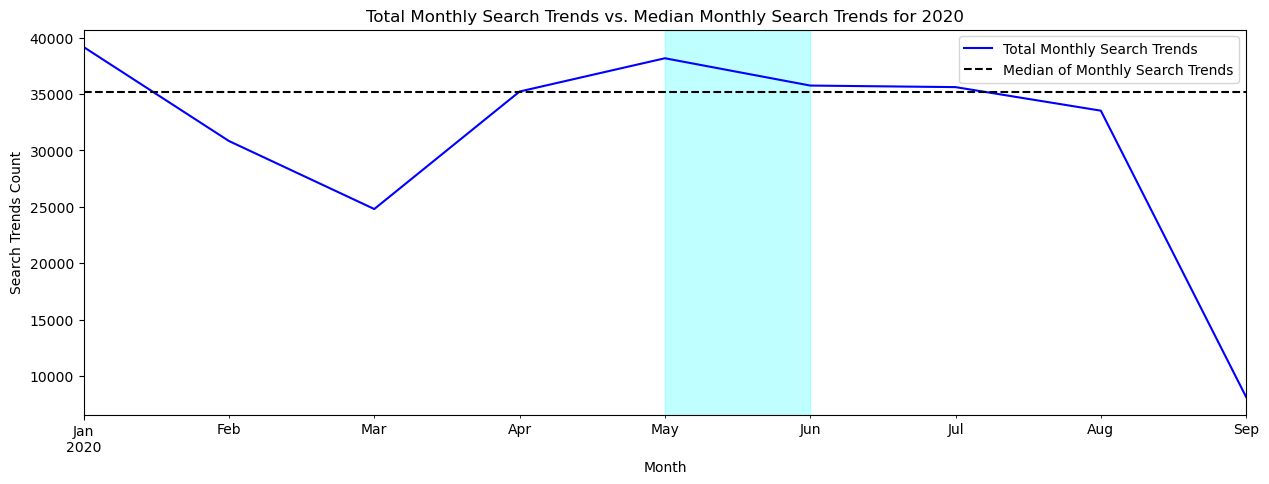

In [252]:
# Visualize the monthly search trends for the year 2020 compared to the median monthly search trends
ax = monthly_search_trends_df_2020.plot(
    y=["Total Monthly Search Trends", "Median of Monthly Search Trends"],
    style=['-', '--'],
    color=['blue', 'black'],
    title=f"Total Monthly Search Trends vs. Median Monthly Search Trends for {select_year}",
    ylabel="Search Trends Count",
    xlabel="Month",
    figsize=(15, 5),
)

# Highlight the range from May 2020 to see any significant changes
start_month = pd.Timestamp(f'{select_year}-05-01')
end_month = pd.Timestamp(f'{select_year}-06-01')

ax.axvspan(start_month, end_month, alpha=0.25, color="cyan", label='May 2020 Highlight')

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

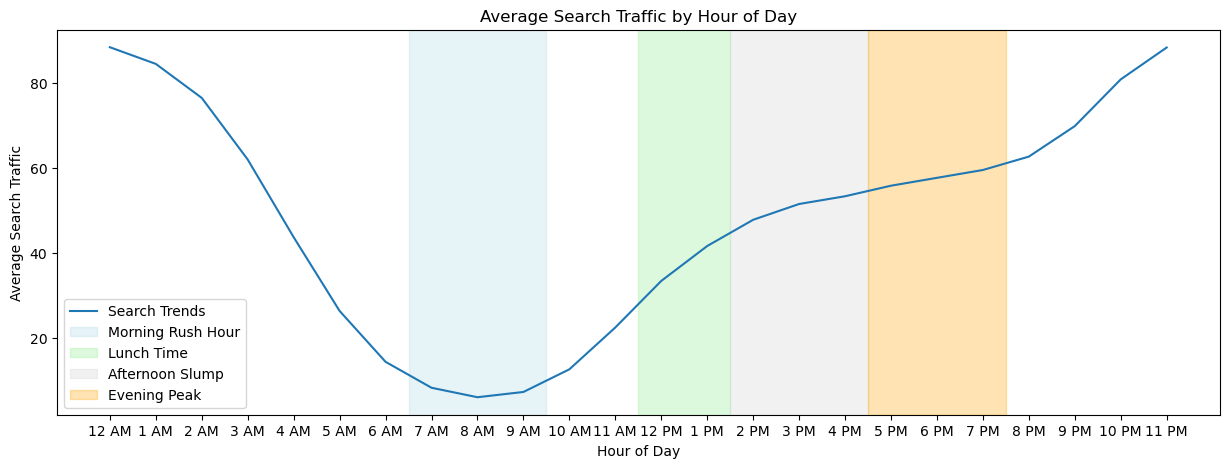

In [309]:
""" 
Important hourly time periods to consider:
    - Morning Rush: When people are commuting to work or school.
    - Lunch Time: When people are on their lunch break.
    - Afternoon Slump: When people are winding down from the day or experiencing a drop in energy.
    - Evening Peak: When people are home from work or school and have free time.
"""

# Group the hourly search data to plot the average traffic by the hour of the day, using `df.index.hour`
hourly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

ax = hourly_avg_traffic.plot(
    title="Average Search Traffic by Hour of Day",
    xlabel="Hour of Day",
    ylabel="Average Search Traffic",
    figsize=(15, 5),
)

hour_labels = [f'{hour % 12 or 12} {"AM" if hour < 12 else "PM"}' for hour in range(24)]
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(hour_labels)

# Highlight important times of day
highlight_times = {
    'Morning Rush Hour': (7, 9, 'lightblue'), # Morning Rush: 7-9 AM
    'Lunch Time': (12, 13, 'lightgreen'), # Lunch Time: 12-1 PM
    'Afternoon Slump': (14, 16, 'lightgray'), # Afternoon Slump: 2-4 PM
    'Evening Peak': (17, 19, 'orange') # Evening Peak: 5-7 PM
}

for label, (start_hour, end_hour, color) in highlight_times.items():
    ax.axvspan(start_hour - 0.5, end_hour + 0.5, alpha=0.3, color=color, label=label)
    
ax.legend()

clear_output()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

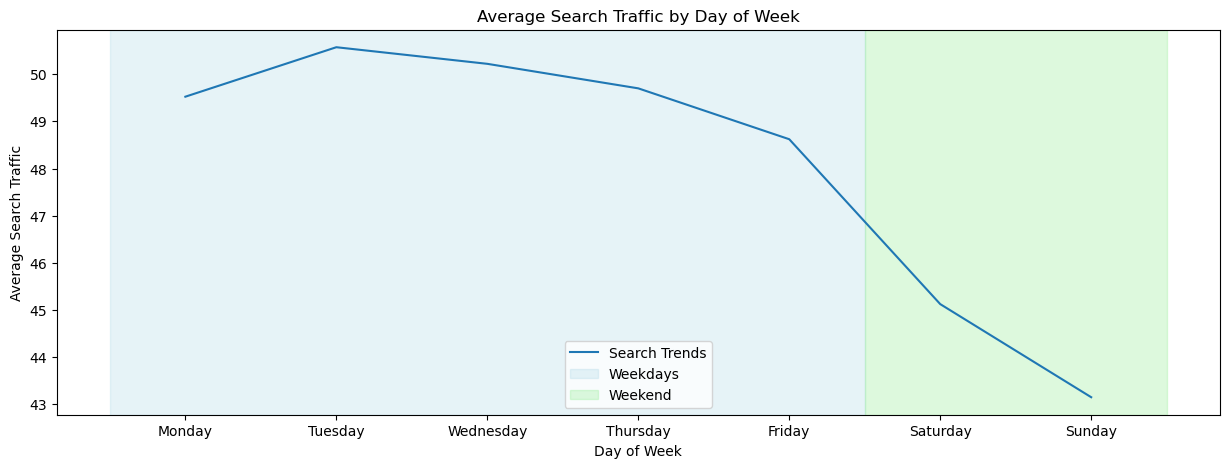

In [308]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()

ax = daily_avg_traffic.plot(
    title="Average Search Traffic by Day of Week",
    xlabel="Day of Week",
    ylabel="Average Search Traffic",
    figsize=(15, 5),
)

day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_xticks(np.arange(1, 8, 1))
ax.set_xticklabels(day_labels)

# Highlight important days of the week
highlight_days = {
    'Weekdays': (1, 5, 'lightblue'),
    'Weekend': (6, 7, 'lightgreen')
}

for label, (start_day, end_day, color) in highlight_days.items():
    ax.axvspan(start_day - 0.5 , end_day + 0.5, alpha=0.3, color=color, label=label)

ax.legend()

clear_output()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

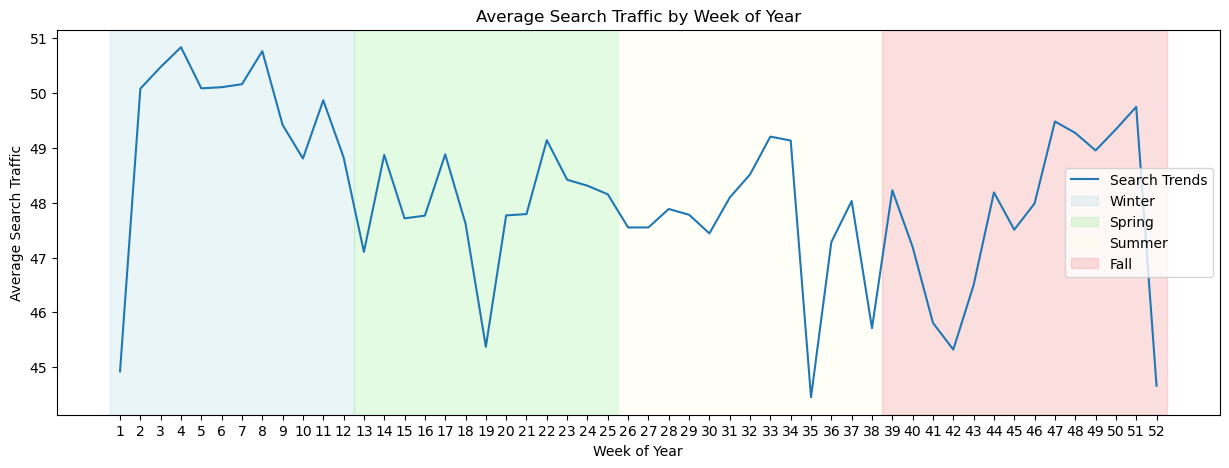

In [287]:
""" 
Important weekly time periods to consider:
    - Winter, Spring, Summer, and Fall seasons.
"""

# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

ax = weekly_avg_traffic.plot(
    title="Average Search Traffic by Week of Year",
    xlabel="Week of Year",
    ylabel="Average Search Traffic",
    figsize=(15, 5),
)

highlight_seasons = {
    'Winter': (1, 12, 'lightblue'),  # Winter: Weeks 1 to 12
    'Spring': (13, 25, 'lightgreen'),  # Spring: Weeks 13 to 25
    'Summer': (26, 38, 'lightyellow'),  # Summer: Weeks 26 to 38
    'Fall': (39, 52, 'lightcoral')  # Fall: Weeks 39 to 52
}

# Highlight the seasons on the plot
for season, (start_week, end_week, color) in highlight_seasons.items():
    ax.axvspan(start_week - 0.5, end_week + 0.5, alpha=0.25, color=color, label=season)

weeks_labels = weekly_avg_traffic.index
ax.set_xticks(weeks_labels)

ax.legend()

clear_output()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [ ]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
print("Shape:", df_mercado_stock.shape)
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

In [ ]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.hvplot(
    title="Closing Price of Mercado Stock",
    xlabel="Date",
    ylabel="Close",
    width=1500,
    height=500,
)

In [ ]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop the rows with only one column of data
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
print("Shape:", mercado_stock_trends_df.shape)
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [ ]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
start_date = "2020-01"
end_date = "2020-06"

df_stock_trends_2020 = mercado_stock_trends_df.loc[start_date:end_date]

# View the first and last five rows of first_half_2020 DataFrame
print("Shape:", df_stock_trends_2020.shape)
display(df_stock_trends_2020.head())
display(df_stock_trends_2020.tail())

In [ ]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
df_stock_trends_2020.plot(subplots=True)

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df["Lagged Search Trends"] = mercado_stock_trends_df["Search Trends"].shift(1)

In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df["Stock Volatility"] = mercado_stock_trends_df["close"].pct_change().rolling(window=4).std()

In [ ]:
# Visualize the stock volatility
mercado_stock_trends_df["Stock Volatility"].plot()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df["Hourly Stock Return"] = mercado_stock_trends_df['close'].pct_change()

In [ ]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
cols = list(mercado_stock_trends_df.columns)
cols.insert(1, cols.pop(cols.index("Hourly Stock Return")))
cols.insert(2, cols.pop(cols.index("Stock Volatility")))
mercado_stock_trends_df = mercado_stock_trends_df[cols]

print("Shape:", mercado_stock_trends_df.shape)
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Hourly Stock Return', 'Stock Volatility', 'Lagged Search Trends']].corr().style.background_gradient()

##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [ ]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends.reset_index(inplace=True)

# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends.columns = ["ds", "y"]

# Drop an NaN values from the prophet_df DataFrame
df_mercado_trends.dropna(inplace=True)

# View the first and last five rows of the mercado_prophet_df DataFrame
print("Shape:", df_mercado_trends.shape)
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

In [ ]:
# Call the Prophet function, store as an object
model = Prophet()
model

In [ ]:
# Fit the time-series model.
model.fit(df_mercado_trends)

In [ ]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq="h")

# View the last five rows of the future_mercado_trends DataFrame
print("Shape:", future_mercado_trends.shape)
future_mercado_trends.tail()

In [ ]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
print("Shape:", forecast_mercado_trends.shape)
forecast_mercado_trends.head()

In [ ]:
for index, value in enumerate(forecast_mercado_trends.columns):
    print(index, value)

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
model.plot(forecast_mercado_trends)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [ ]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index("ds", inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[["yhat", "yhat_lower", "yhat_upper"]]

Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [ ]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

plot_columns = ["yhat", "yhat_lower", "yhat_upper"]
filter_time = forecast_mercado_trends.index[-2000:]

forecast_mercado_trends[plot_columns].loc[filter_time, :].hvplot(
    title="Forecasted Mercado Search Trends",
    xlabel="Date",
    ylabel="Search Trend",
    width=1500,
    height=500,
)

In [ ]:
print("Predicted Date Range:")
print("Start Date:", filter_time.min())
print("End Date:", filter_time.max())

In [ ]:
start_date = "2020-06-01 08:00:00"
end_date = "2020-06-02 08:00:00"

predicted_values_y = forecast_mercado_trends.loc[start_date:end_date, ["yhat"]]
predicted_values_y_lower = forecast_mercado_trends.loc[start_date:end_date, ["yhat_lower"]]
predicted_values_y_upper = forecast_mercado_trends.loc[start_date:end_date, ["yhat_upper"]]

actual_values = df_mercado_trends.loc[(df_mercado_trends["ds"] >= start_date) & (df_mercado_trends["ds"] <= end_date), ["ds", "y"]]
actual_values.set_index("ds", inplace=True)

comparison_df = pd.concat([actual_values, predicted_values_y, predicted_values_y_lower, predicted_values_y_upper], axis=1)
comparison_df.columns = ["Actual", "Predicted", "Predicted Lower", "Predicted Upper"]

comparison_df["Difference"] = comparison_df["Actual"] - comparison_df["Predicted"]

# comparison_df = pd.concat([actual_values, predicted_values], axis=1)
# comparison_df.columns = ["Actual", "Predicted"]

# comparison_df["Difference"] = comparison_df["Actual"] - comparison_df["Predicted"]

# round 2 decimal places
display(comparison_df[["Actual", "Predicted", "Difference"]].apply(lambda x: round(x, 2)).head())
display(comparison_df[["Actual", "Predicted", "Difference"]].apply(lambda x: round(x, 2)).tail())

comparison_df.hvplot(
    title="Actual vs. Predicted Search Trends",
    xlabel="Date",
    ylabel="Search Trend",
    width=1500,
    height=500,
)

In [ ]:
# Test prediction vs real data to see how well the model is performing
select_date = "2020-06-01 08:00:00"

predicted_value = forecast_mercado_trends.loc[select_date, "yhat"]

actual_value = df_mercado_trends.loc[df_mercado_trends["ds"] == select_date, "y"].values[0]

# Compare the predicted value with the actual observed value
print(f"Predicted value for {select_date}: {predicted_value}")
print(f"Actual value for {select_date}: {actual_value}")
print(f"Difference: {actual_value - predicted_value}")

In [ ]:
forecast_mercado_trends

In [ ]:
# Reset the index in the forecast_mercado_trends DataFrame
# forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast_mercado_trends)
clear_output()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**

**Question:** Which day of week gets the most search traffic?
   
**Answer:**

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**
